In [ ]:
# default_exp feature

# Feature

> Module for working with local features: keypoints, detectors, matches, etc.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import cv2
import torch
import kornia as K
from typing import List, Union, Tuple, Optional
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

def laf_from_opencv_kpts(kpts: List[cv2.KeyPoint], 
                         mrSize: float=6.0,
                         device: torch.device=torch.device('cpu'),
                         with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    N = len(kpts)
    xy = torch.tensor([(x.pt[0], x.pt[1]) for x in kpts ], device=device, dtype=torch.float).view(1, N, 2)
    scales = torch.tensor([(mrSize * x.size) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1, 1)
    angles = torch.tensor([(-x.angle) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1)
    laf = K.feature.laf_from_center_scale_ori(xy, scales, angles).reshape(1, -1, 2, 3)
    if not with_resp:
        return laf.reshape(1, -1, 2, 3)
    resp = torch.tensor([x.response for x in kpts], device=device, dtype=torch.float).view(1, N, 1)
    return laf, resp

def visualize_LAF(img, LAF, img_idx = 0, color='r', **kwargs):
    x, y = K.feature.laf.get_laf_pts_to_draw(K.feature.laf.scale_laf(LAF, 0.5), img_idx)
    plt.figure(**kwargs)
    plt.imshow(K.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, color)
    plt.show()
    return

def opencv_kpts_from_laf(lafs: torch.Tensor,
                         mrSize: float = 1.0, 
                         resps: Optional[torch.Tensor] = None) -> List[cv2.KeyPoint]:
    XY = K.feature.get_laf_center(lafs)
    S = K.feature.get_laf_scale(lafs)
    Ang = K.feature.get_laf_orientation(lafs)
    if resps is not None:
        assert resps.shape[:2] == lafs.shape[:2]
        cv_kpts = [cv2.KeyPoint(xy[0].item(), xy[1].item(), s.item()/mrSize, -a.item(), r.item()) 
                   for xy, s, a, r in zip(XY.view(-1,2), S.view(-1, 1), Ang.view(-1, 1), resps.view(-1, 1))]
    else:
        cv_kpts = [cv2.KeyPoint(xy[0].item(), xy[1].item(), s.item()/ mrSize, -a.item()) 
                   for xy, s, a in zip(XY.view(-1,2), S.view(-1, 1), Ang.view(-1, 1))]        
    return cv_kpts

Let's detect ORB keypoints and convert them to and from OpenCV

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


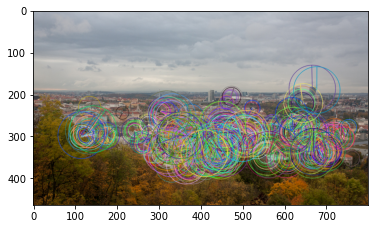

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


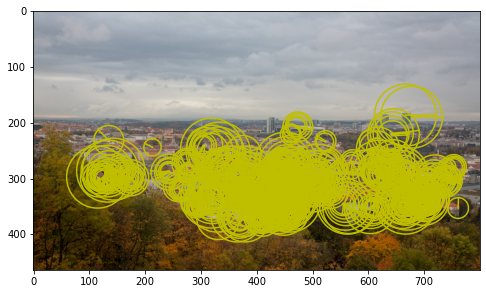

In [ ]:
lafs, r = laf_from_opencv_kpts(kps, 1.0, with_resp=True)
visualize_LAF(K.image_to_tensor(img, False), lafs, 0, 'y', figsize=(8,6))

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


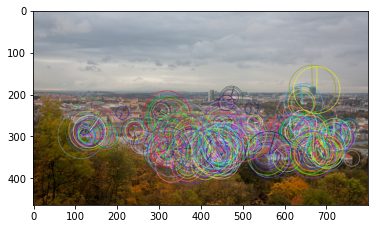

In [ ]:
kps_back = opencv_kpts_from_laf(lafs, 1.0, r)
out_img = cv2.drawKeypoints(img, kps_back, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

OpenCV uses different conventions for the local feature scale. 

E.g. to get equivalent kornia LAF from ORB keypoints, one should you mrSize = 0.5, 
while for SIFT -- 6.0. The orientation convention is also different for kornia and OpenCV.

In [ ]:
#export 
def laf_from_opencv_ORB_kpts(kpts: List[cv2.KeyPoint], 
                             device: torch.device=torch.device('cpu'),
                             with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    return laf_from_opencv_kpts(kpts, 1.0, device, with_resp)

def laf_from_opencv_SIFT_kpts(kpts: List[cv2.KeyPoint], 
                              device: torch.device=torch.device('cpu'),
                              with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    return laf_from_opencv_kpts(kpts, 6.0, device, with_resp)


def opencv_SIFT_kpts_from_laf(lafs, resps: Optional[torch.Tensor] = None):
    return opencv_kpts_from_laf(lafs, 6.0, resps);

def opencv_ORB_kpts_from_laf(lafs, resps: Optional[torch.Tensor] = None):
    return opencv_kpts_from_laf(lafs, 1.0, resps);


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


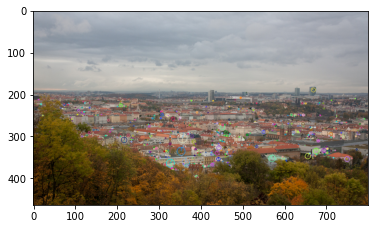

In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.SIFT_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

The keypoints are small, because, unlike for ORB, for SIFT OpenCV draws not real regions to be described, but the radius of the blobs, which are detected. Kornia and kornia_moons, inlike OpenCV, shows the real description region.

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


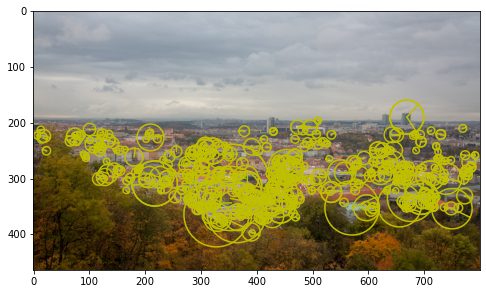

In [ ]:
lafs, r = laf_from_opencv_SIFT_kpts(kps, with_resp=True)
visualize_LAF(K.image_to_tensor(img, False), lafs, 0, 'y', figsize=(8,6))

If you want to see the image, similar to OpenCV one, you can scale LAFs by factor 1/12.

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


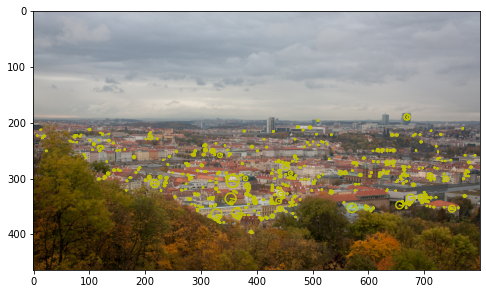

In [ ]:
visualize_LAF(K.image_to_tensor(img, False), K.feature.laf.scale_laf(lafs, 1./6.0), 0, 'y', figsize=(8,6))

Now let's do the same for matches format

In [ ]:
#export
def cv2_matches_from_kornia(match_dists: torch.Tensor, match_idxs: torch.Tensor) -> List[cv2.DMatch]:
    return [cv2.DMatch(idx[0].item(), idx[1].item(), d.item()) for idx, d in zip (match_idxs, match_dists)]

def kornia_matches_from_cv2(cv2_matches, device=torch.device('cpu')):
    num_matches = len(cv2_matches)
    match_dists = torch.zeros(num_matches, 1, device=device, dtype=torch.float)
    match_idxs = torch.zeros(num_matches, 2, device=device, dtype=torch.long)
    for i, m in enumerate(cv2_matches):
        match_dists[i, 0] = m.distance
        match_idxs[i, 0] = m.queryIdx
        match_idxs[i, 1] = m.trainIdx
    return match_dists, match_idxs

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


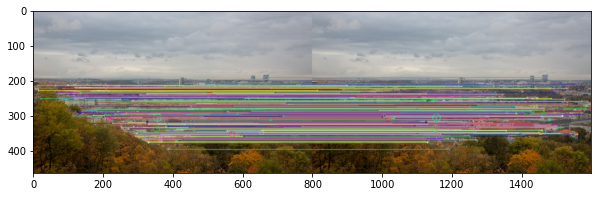

In [ ]:
from torch import allclose
match_dists, match_idxs = K.feature.match_nn(torch.from_numpy(descs).float(),
                                             torch.from_numpy(descs).float())

cv2_matches = cv2_matches_from_kornia(match_dists, match_idxs)
out_img = cv2.drawMatches(img, kps, img, kps, cv2_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,5))
plt.imshow(out_img)

match_dists_back, match_idxs_back = kornia_matches_from_cv2(cv2_matches)

assert(allclose(match_dists_back, match_dists))
assert(allclose(match_idxs_back, match_idxs))

In [ ]:
#export 
from typing import Union

def to_numpy_image(img: Union[str, np.array, torch.Tensor]):
    if type(img) is str:
        img_out = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    elif isinstance(img, torch.Tensor):
        img_out = K.tensor_to_image(img)
    elif isinstance(img, np.ndarray):
        img_out = img
    else:
        raise TypeError('img should be str, np.array or torch.Tensor')
    return img_out

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
assert isinstance(to_numpy_image('data/strahov.png'), np.ndarray)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#export 
def epilines_to_start_end_points(epi, h, w):
    num = len(epi)
    zeros = torch.zeros(num)
    ones = torch.ones(num)
    eps = 1e-8

    
    b = -epi[:,2] / (epi[:,1] + eps)
    k = -epi[:,0] / (epi[:,1] + eps)
    k_positive = k >= 0
    k_negative = k < 0
    
    
    # We find the points of crossing x = 0, x = w, y = 0, y = h
    p1 = torch.stack([zeros,  b], axis=-1)
    p2 = torch.stack([w*ones, k*w + b], axis =-1)
    p3 = torch.stack([-b/(k + eps), zeros], axis=-1)
    p4 = torch.stack([(h - b)/(k + eps), ones*h], axis=-1)
    
    # Now we select those, which are inside of image
    p1_is_start = (p1[:, 1:2] <= h) & (p1[:, 1:2] >= 0)
    p3_is_start = (k_positive * (~p1_is_start.view(-1))).view(-1,1)
    p4_is_start = (k_negative * (~p1_is_start.view(-1))).view(-1,1)
    none_is_start = ~(p1_is_start | p3_is_start |  p4_is_start)
    
    
    p2_is_fin  = (p2[:, 1:2] <= h) & (p2[:, 1:2] >= 0)
    p4_is_fin  = (k_positive * (~p2_is_fin.view(-1))).view(-1,1)
    p3_is_fin  = (k_negative * (~p2_is_fin.view(-1))).view(-1,1)
    
    
    start_lines = p1 * p1_is_start.float() + p3 * p3_is_start.float() + p4 * p4_is_start.float()
    fin_lines   = p2 * p2_is_fin.float()   + p4 * p4_is_fin.float() + p3 * p3_is_fin.float()
    return torch.stack ([start_lines, fin_lines])

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import kornia.geometry as KG
help(KG.perspective_transform_lafs)

Help on function perspective_transform_lafs in module kornia.geometry.linalg:

perspective_transform_lafs(trans_01: torch.Tensor, lafs_1: torch.Tensor) -> torch.Tensor
    Function that applies perspective transformations to a set of local affine frames (LAFs).
    
    Args:
        trans_01: tensor for perspective transformations of shape :math:`(B, 3, 3)`.
        lafs_1: tensor of lafs of shape :math:`(B, N, 2, 3)`.
    
    Returns:
        tensor of N-dimensional points of shape :math:`(B, N, 2, 3)`.
    
    Examples:
        >>> rng = torch.manual_seed(0)
        >>> lafs_1 = torch.rand(2, 4, 2, 3)  # BxNx2x3
        >>> lafs_1
        tensor([[[[0.4963, 0.7682, 0.0885],
                  [0.1320, 0.3074, 0.6341]],
        <BLANKLINE>
                 [[0.4901, 0.8964, 0.4556],
                  [0.6323, 0.3489, 0.4017]],
        <BLANKLINE>
                 [[0.0223, 0.1689, 0.2939],
                  [0.5185, 0.6977, 0.8000]],
        <BLANKLINE>
                 [[0.1610, 0.

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#export
import kornia as K
import kornia.feature as KF
import torch
def draw_LAF_matches(lafs1, lafs2, tent_idxs,  
                        img1, img2, inlier_mask = None, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                                  "vertical": False}, 
                        Fm: Optional[np.array] = None, H: Optional[np.array] = None,
                        ax: Optional = None):
    '''This function draws LAFs, tentative matches, inliers epipolar lines (if F is provided),
    and image1 corners reprojection into image 2 (if H is provided)'''
    inlier_mask = np.array(inlier_mask).reshape(-1)
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)
    
    h,w = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    corners_pts = np.float32([[0, 0],
                              [0, h-1],
                              [w-1, h-1],
                              [w-1, 0],
                              [0, 0] ]).reshape(-1,1,2)
        
    
    img2_tr = deepcopy(img2)
    
    xy1 = KF.get_laf_center(lafs1).reshape(-1, 2)
    xy2 = KF.get_laf_center(lafs2).reshape(-1, 2)
    # If we have no axes, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,10))

    tent_cv2 = cv2_matches_from_kornia(torch.ones(len(tent_idxs)), tent_idxs)
    tent_corrs = torch.stack([xy1[tent_idxs[:,0]], xy2[tent_idxs[:,1]]])
    try:
        vert = draw_dict['vertical']
    except:
        vert = False
    if vert:
        tent_corrs[1,:,1]+=h # shift for the 2nd image
    else:
        tent_corrs[1,:,0]+=w # shift for the 2nd image
    if H is not None:
        dst_corners = cv2.perspectiveTransform(corners_pts, H)
        if vert:
            dst_corners[...,1]+=h
        else:
            dst_corners[...,0]+=w
    # Prepraring canvas
    if not vert:
        if len(img1.shape) == 3:
            new_shape = (max(h, h2), w + w2, img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (max(h, h2), w + w2)
    else:
        if len(img1.shape) == 3:
            new_shape = (h + h2,  max(w, w2), img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (h + h2,  max(w, w2))        
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    if not vert:
        new_img[0:h, 0:w] = img1
        new_img[0:h2, w:w + w2] = img2
    else:
        new_img[0:h, 0:w] = img1
        new_img[h:h+h2, 0:w2] = img2

    x1,y1 = KF.laf.get_laf_pts_to_draw(lafs1, 0)
    x2,y2 = KF.laf.get_laf_pts_to_draw(lafs2, 0)
    if vert:
        y2+=h
    else:
        x2+=w
    # Drawing features
    try:
        fc = draw_dict['feature_color']
    except:
        fc = None
    if fc is not None:
        ax.plot(x1, y1, color=fc)
        ax.plot(x2, y2, color=fc)
        
    #Drawgin tentatives
    try:
        tc = draw_dict['tentative_color']
    except:
        tc = None
    if tc is not None:
        ax.plot(tent_corrs[...,0], tent_corrs[...,1], color=tc)
        ax.plot(x1[:, tent_idxs[:,0]], y1[:, tent_idxs[:,0]], color=tc)
        ax.plot(x2[:, tent_idxs[:,1]], y2[:, tent_idxs[:,1]], color=tc)
    try:
        ic = draw_dict['inlier_color']
    except:
        ic = None
    if (ic is not None) and (inlier_mask is not None):
        inlier_mask = inlier_mask > 0
        ax.plot(tent_corrs[..., inlier_mask, 0], tent_corrs[...,inlier_mask, 1], color=ic)
        ax.plot(x1[:, tent_idxs[inlier_mask,0]], y1[:, tent_idxs[inlier_mask,0]], color=ic)
        ax.plot(x2[:, tent_idxs[inlier_mask,1]], y2[:, tent_idxs[inlier_mask,1]], color=ic)
    if H is not None:
        ax.plot(corners_pts[:,0,0], corners_pts[:,0,1], color=(0,0,1))
        ax.plot(dst_corners[:,0,0], dst_corners[:,0,1], color=(0,0,1))
    if (Fm is not None):
        if inlier_mask is None:
            inlier_mask = [True for i in range(len(tent_idxs))]
        tent_corrs2 = torch.stack([xy1[tent_idxs[:,0]], xy2[tent_idxs[:,1]]])
        inl1 = tent_corrs2[0, inlier_mask]
        inl2 = tent_corrs2[1, inlier_mask]
        Ff = torch.from_numpy(Fm).float()
        epi1 = K.geometry.compute_correspond_epilines(inl2.reshape(1,-1, 2), Ff.t()[None])[0]
        epiline1 = epilines_to_start_end_points(epi1, h, w)
        
        epi2 = K.geometry.compute_correspond_epilines(inl1.reshape(1,-1, 2), Ff[None])[0]
        epiline2 = epilines_to_start_end_points(epi2, h2, w2)
        if vert:
            epiline2[...,1]+=h # shift for the 2nd image
        else:
            epiline2[...,0]+=w # shift for the 2nd image            
        
        ax.plot(epiline1[:,:,0], epiline1[:,:,1], color='purple')
        ax.plot(epiline2[:,:,0], epiline2[:,:,1], color='purple')
    # Finally clip the image
    ax.imshow(new_img)
    if not vert:
        ax.set_xlim([0,w+w2])
        ax.set_ylim([max(h,h2),0])
        ax.margins(0,0)
    else:
        ax.set_xlim([0,max(w,w2)])
        ax.set_ylim([h+h2, 0])
        ax.margins(0,0)
    return 

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We will visualize ORB features (blue), tentative matches (yellow) and inliers(greenish)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


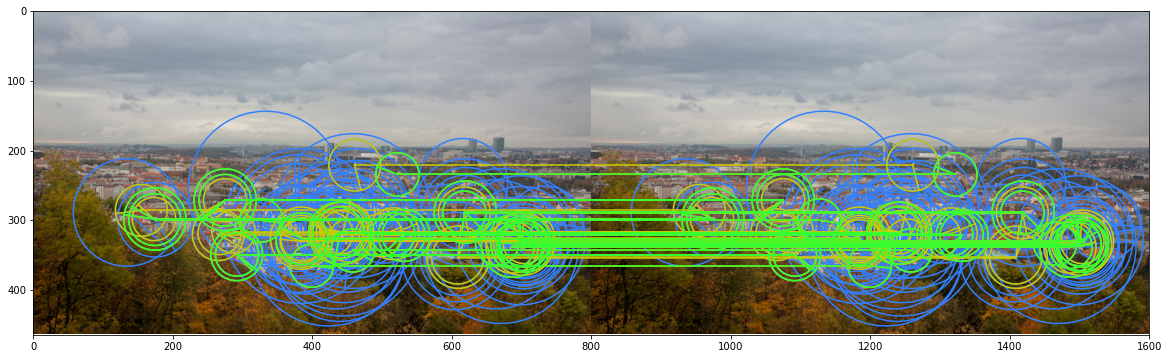

In [ ]:
import numpy as np
det = cv2.ORB_create(100)
img1_fname = 'data/strahov.png'
kps1, descs1 = det.detectAndCompute(cv2.imread(img1_fname,0), None)
lafs1 = laf_from_opencv_ORB_kpts(kps1)
idxs = torch.stack([torch.arange(50),torch.arange(50)], dim=-1)
draw_LAF_matches(lafs1, lafs1, idxs,
                  img1_fname,img1_fname, 
                  [True if i%2 == 0 else False for i in range(len(idxs))],
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                              "vertical": False})

Now let's try with epipolar matrix for the translation. Inliers should lie on the horizontal epipolar lines

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


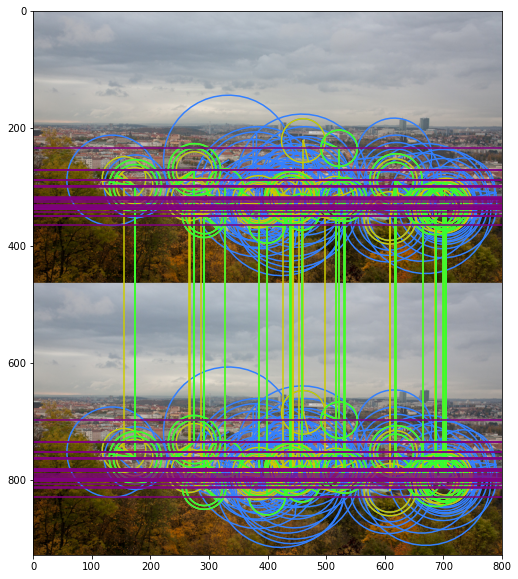

In [ ]:
Fmat = np.array([[0., 0., 0.],
                 [0, 0, -1],
                [0, 1, 0]])
draw_LAF_matches(lafs1, lafs1, idxs,
                  img1_fname,img1_fname, 
                  [True if i%2 == 0 else False for i in range(len(idxs))],
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                              "vertical": True}, Fm = Fmat)

Now we will transform the image, match it, find the homography and visualize it.

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


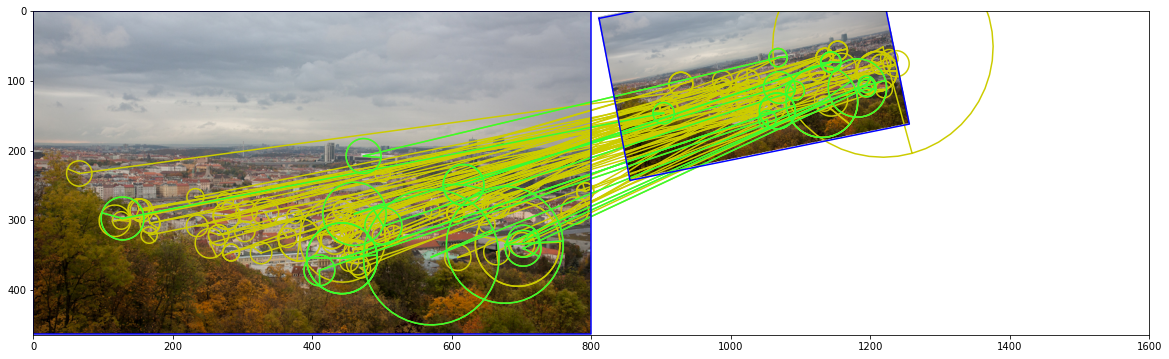

In [ ]:
import numpy as np
det = cv2.SIFT_create(100)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.5, 0.1, 10],
                [-0.1, 0.5, 10],
               [0, 0, 1]])
img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))



kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)


match_dists, match_idxs = K.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.98)

H, mask = cv2.findHomography(KF.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             KF.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_matches(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask,
                  draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": None,
                              "vertical": False}, H = H)

And the same with fundamental matrix

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


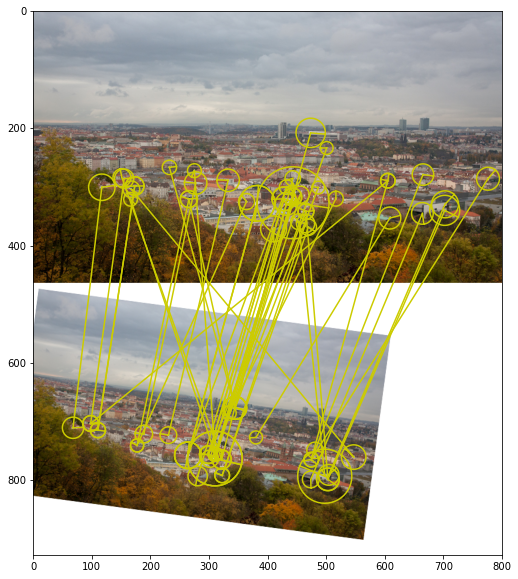

In [ ]:
import numpy as np
det = cv2.SIFT_create(75)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.75, -0.1, 10],
                [0.1, 0.75, 10],
               [0, 0, 1]])

img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))


kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)



match_dists, match_idxs = K.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.95)

Fmat, mask = cv2.findFundamentalMat(KF.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             KF.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_matches(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask,
                  draw_dict={"inlier_color": None,#(0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": None,
                              "vertical": True})

In [ ]:
#export
def draw_LAF_matches_from_result_dict(result_dict,
                        img1, img2, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                                  "vertical": False}):
    if 'H' in result_dict:
        H = result_dict['H']
    else:
        H = None
    if 'F' in result_dict:
        Fm = result_dict['F']
    else:
        Fm = None
    return draw_LAF_matches(result_dict['feat_dict1']['lafs'], 
                        result_dict['feat_dict2']['lafs'],
                               result_dict['tents_dict']['idxs'],  
                        img1, img2, result_dict['inlier_mask'], 
                        draw_dict, Fm, H)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#export
import kornia as K
import kornia.feature as KF
import torch
def draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, tent_idxs,  
                        img1, img2, inlier_mask = None, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "reprojected_color": (0.2, 0.5, 1),
                                "vertical": False}, 
                        H: np.array = None,
                        ax: Optional = None):
    '''This function draws tentative matches and inliers given the homography H'''
    inlier_mask = np.array(inlier_mask).reshape(-1)
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)
    
    h,w = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    img2_tr = deepcopy(img2)
    
    lafs1_in2 = KG.perspective_transform_lafs(torch.from_numpy(H).float()[None],
                                              lafs1)
    lafs2_in1 = KG.perspective_transform_lafs(torch.inverse(torch.from_numpy(H).float()[None]),
                                              lafs2)
    xy1 = KF.get_laf_center(lafs1).reshape(-1, 2)
    xy2 = KF.get_laf_center(lafs2).reshape(-1, 2)
    
    # If we have no axes, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,10))

    tent_corrs_in1 = torch.stack([xy1[tent_idxs[:,0]],
                                  KF.get_laf_center(lafs2_in1).reshape(-1, 2)[tent_idxs[:,1]]])
    
    tent_corrs_in2 = torch.stack([KF.get_laf_center(lafs1_in2).reshape(-1, 2)[tent_idxs[:,0]],
                                  xy2[tent_idxs[:,1]]])
    
    try:
        vert = draw_dict['vertical']
    except:
        vert = False
    if vert:
        tent_corrs_in2[:,:,1]+=h # shift for the 2nd image
    else:
        tent_corrs_in2[:,:,0]+=w # shift for the 2nd image
    # Prepraring canvas
    if not vert:
        if len(img1.shape) == 3:
            new_shape = (max(h, h2), w + w2, img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (max(h, h2), w + w2)
    else:
        if len(img1.shape) == 3:
            new_shape = (h + h2,  max(w, w2), img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (h + h2,  max(w, w2))        
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    if not vert:
        new_img[0:h, 0:w] = img1
        new_img[0:h2, w:w + w2] = img2
    else:
        new_img[0:h, 0:w] = img1
        new_img[h:h+h2, 0:w2] = img2

    x1,y1 = KF.laf.get_laf_pts_to_draw(lafs1, 0)
    x2,y2 = KF.laf.get_laf_pts_to_draw(lafs2, 0)
    
    x1in2, y1in2 = KF.laf.get_laf_pts_to_draw(lafs1_in2, 0)
    x2in1, y2in1 = KF.laf.get_laf_pts_to_draw(lafs2_in1, 0)
    
    if vert:
        y2+=h
        y1in2+=h
    else:
        x2+=w
        x1in2+=w
        
    try:
        ic = draw_dict['inlier_color']
    except:
        ic = None
    if (ic is not None) and (inlier_mask is not None):
        inlier_mask = inlier_mask > 0
        ax.plot(tent_corrs_in1[..., inlier_mask, 0], tent_corrs_in1[...,inlier_mask, 1], color=ic)
        ax.plot(tent_corrs_in2[..., inlier_mask, 0],
                tent_corrs_in2[...,inlier_mask, 1], color=ic)
        ax.plot(x1[:, tent_idxs[inlier_mask,0]], y1[:, tent_idxs[inlier_mask,0]], color=ic)
        ax.plot(x2[:, tent_idxs[inlier_mask,1]], y2[:, tent_idxs[inlier_mask,1]], color=ic)
    try:
        rc = draw_dict['reprojected_color']
    except:
        rc = None
    if rc is not None:
        inlier_mask = inlier_mask > 0
        ax.plot(x1in2[:, tent_idxs[inlier_mask,0]], y1in2[:, tent_idxs[inlier_mask,0]], color=rc)
        ax.plot(x2in1[:, tent_idxs[inlier_mask,1]], y2in1[:, tent_idxs[inlier_mask,1]], color=rc)

    # Finally clip the image
    ax.imshow(new_img)
    if not vert:
        ax.set_xlim([0,w+w2])
        ax.set_ylim([max(h,h2),0])
        ax.margins(0,0)
    else:
        ax.set_xlim([0,max(w,w2)])
        ax.set_ylim([h+h2, 0])
        ax.margins(0,0)
    return 

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


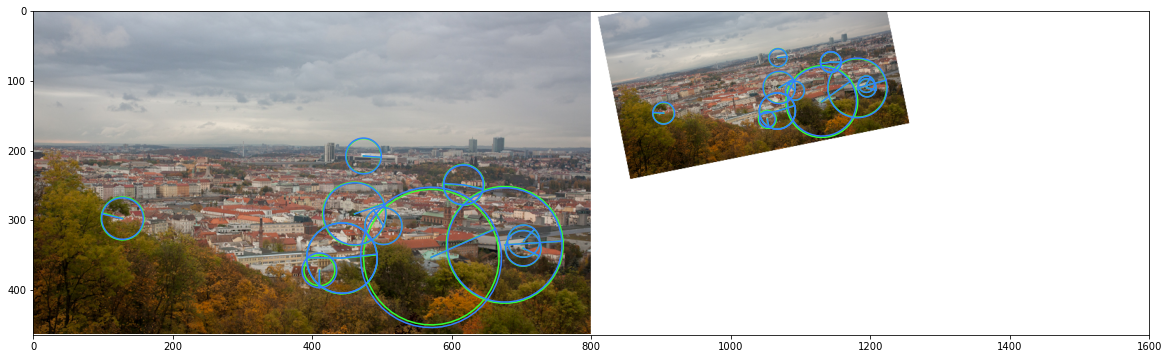

In [ ]:
import numpy as np
det = cv2.SIFT_create(100)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.5, 0.1, 10],
                [-0.1, 0.5, 10],
               [0, 0, 1]])
img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))



kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)


match_dists, match_idxs = K.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.98)

H, mask = cv2.findHomography(KF.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             KF.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask, H = H)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted feature.ipynb.
Converted index.ipynb.


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
